<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#Why-considering-CNN-for-timeseries?" data-toc-modified-id="Why-considering-CNN-for-timeseries?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Why considering CNN for timeseries?</a></span></li><li><span><a href="#Import-the-dataset" data-toc-modified-id="Import-the-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Import the dataset</a></span></li><li><span><a href="#Develop-a-test-harness" data-toc-modified-id="Develop-a-test-harness-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Develop a test harness</a></span><ul class="toc-item"><li><span><a href="#Train-Test-split" data-toc-modified-id="Train-Test-split-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Train-Test split</a></span></li><li><span><a href="#Series-to-supervised-transformation" data-toc-modified-id="Series-to-supervised-transformation-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Series-to-supervised transformation</a></span></li><li><span><a href="#Walk-forward-validation" data-toc-modified-id="Walk-forward-validation-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Walk-forward validation</a></span></li><li><span><a href="#Repeat-evaluation" data-toc-modified-id="Repeat-evaluation-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Repeat evaluation</a></span></li><li><span><a href="#Compute-the-loss" data-toc-modified-id="Compute-the-loss-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Compute the loss</a></span></li><li><span><a href="#Modeling-&amp;-Fitting" data-toc-modified-id="Modeling-&amp;-Fitting-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Modeling &amp; Fitting</a></span></li><li><span><a href="#Inference/prediction" data-toc-modified-id="Inference/prediction-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Inference/prediction</a></span></li><li><span><a href="#Results-summary" data-toc-modified-id="Results-summary-5.8"><span class="toc-item-num">5.8&nbsp;&nbsp;</span>Results summary</a></span></li></ul></li><li><span><a href="#Run-the-model" data-toc-modified-id="Run-the-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Run the model</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** CNN applied to univariate timeseries

</font>
</div>

# Import modules
<hr style="border:2px solid black"> </hr>

In [2]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot
from matplotlib import rcParams

# Why considering CNN for timeseries?
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- CNNs, are generally used for image-based application. Nervetheless, they can be used for one-dimensional data such as sequences of text and time series.

- When operating on one-dimensional data, the CNN reads across a sequence of lag observations and learns to extract  **automatically** features that are relevant for making a prediction.

- CNNs are great for computer vision, because they’re able to catch the finest details (local patterns) in images or even 3D volumetric data, but they can be applied for even more simple 1D data.

- All we need to do is to take the open sourced state of the art deep learning architecture like ResNet or DenseNet and replace 2D convolutions with 1D ones.

</font>
</div>

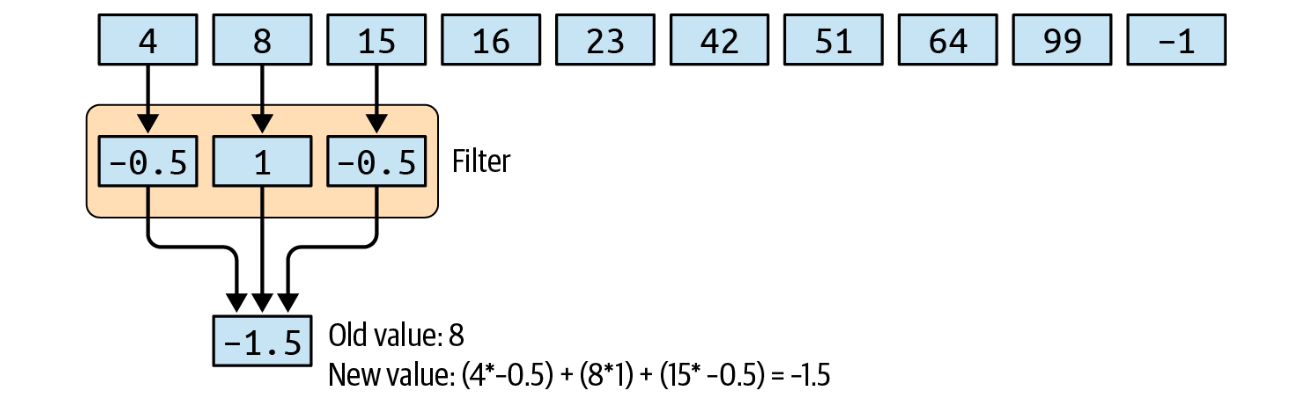

# Import the dataset
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- The *monthly car sales* dataset summarizes the monthly car sales in Quebec, Canada between 1960 and 1968.
- The dataset is monthly and has nine years, or 108 observations. 
- The dataset has an **obvious** trend and seasonal component. The period of the seasonal component could be six months or 12 months.
- You generally have the option to remove the seaonal component and this is done most of the time. We said we have the option. **This means that there is no theoretical reason why you MUST**. In this tutorial, it is shown how to create a test harness and accuracy is secondary.

</font>
</div>

In [3]:
series = read_csv('../../DATASETS/monthly-car-sales.csv',
                  header=0, index_col=0)
data = series.values

In [4]:
print(series.shape)

(108, 1)


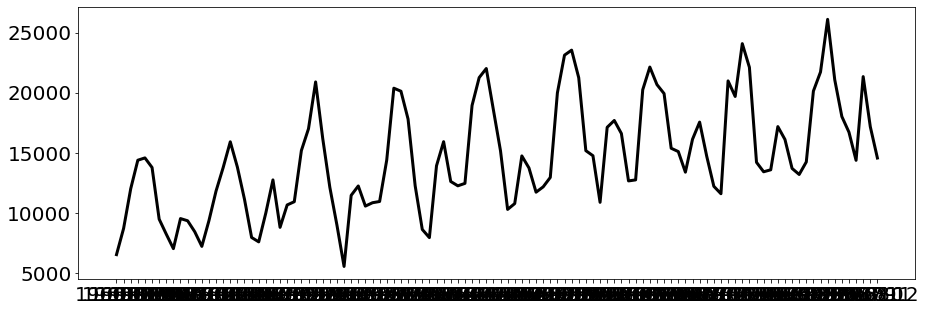

In [6]:
rcParams['figure.figsize'] = 15, 5
rcParams['font.size'] = 20
pyplot.plot(series, lw = 3, c= "k")
pyplot.show()

# Develop a test harness
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- A test harness is nothing more that a series of standardised actions you perform to evaluate a model.
- In this case, we have 5 steps:
    - Train-Test Split
    - Series as Supervised Learning
    - Walk-Forward Validation
    - Repeat Evaluation
    - Summarize Performance

</font>
</div>

## Train-Test split

In [7]:
def train_test_split(data, n_test):
    """Split data
    Split a univariate dataset into train/test sets
    """
    return data[:-n_test], data[-n_test:]

## Series-to-supervised transformation

<div class="alert alert-info">
<font color=black>

- Transform list into supervised learning format. This means that each sample must have both an input component and an output component.
- The input component will be some number of prior observations, such as three years or 36 time steps.
- The output component will be the total sales in the next month because we are interested in developing a model to make one-step forecasts.  

</font>
</div>

In [8]:
def series_to_supervised(data, n_in=1, n_out=1):
    """Series to supervised problem
    """

    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

## Walk-forward validation

<div class="alert alert-info">
<font color=black>

- Walk Forward Validation:  it is called like this because this methodology involves moving along the time series one-time step at a time. Additionally, because a sliding or expanding window is used to train a model, this method is also referred to as Rolling Window Analysis or a Rolling Forecast. You can see that many more models are created. 
- This has the benefit again of providing a much more robust estimation of how the chosen modelling method and parameters will perform in practice.  This improved estimate comes at the computational cost of creating so many models. This is not expensive if the modelling method is simple or dataset is small, but could be an issue at scale.
- Walk-forward validation is the **gold standard** of model evaluation. It is the k-fold cross-validation for time series. Essentially a model may be updated each time step new data is received.

</font>
</div>

In [12]:
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

## Repeat evaluation

<div class="alert alert-info">
<font color=black>

- Neural network models are stochastic and the results is that if everything stay the same but the model is trained multiple times the performance will be different.
- This is a benefit, allowing the model to be adaptive and find high performing configurations to complex problems.
- To address this wie'll evaluate the model several times.

</font>
</div>

In [13]:
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config)
              for _ in range(n_repeats)]
    return scores

## Compute the loss

In [9]:
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

## Modeling & Fitting

<div class="alert alert-info">
<font color=black>

- We will define a CNN with two convolutional layers for extracting features from the input sequences. Each will have a configurable number of filters and kernel size and will use the rectified linear activation function. The number of filters determines the number of parallel fields on which the weighted inputs are read and projected. The kernel size defines the number of time steps read within each snapshot as the network reads along the input sequence. 

- A max pooling layer is used after convolutional layers to distill the weighted input features into those that are most salient, reducing the input size by 1/4. The pooled inputs are flattened to one long vector before being interpreted and used to make a one-step prediction.

- The CNN model expects input data to be in the form of multiple samples, where each sample has multiple input time steps.

- CNN can support multiple features or types of observations at each time step, which are interpreted as channels of an image. We only have a single feature at each time step, therefore the required three-dimensional shape of the input data will be [n_samples, n_input, 1].

</font>
</div>

In [10]:
def model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel,
              activation='relu', input_shape=(n_input, 1)))
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

## Inference/prediction

<div class="alert alert-info">
<font color=black>

- CNNs requires that we specify the number of features observed at each time step, which in this case is 1. 
- Thus, when making a single one-step prediction, the shape of the input array must be: `[1, n_input, 1]`

</font>
</div>

In [11]:
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

## Results summary

In [14]:
def summarize_scores(scores):
    """ Summaruse the results.
    
    Thebox plot helps us understand the spread of the results.
    """
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%.3f RMSE (+/- %.3f)' % (scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

# Run the model
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- The CNN architecture and hyperparameters is described by `config`:
- `config = [n_input, n_filters, n_kernel, n_epochs, n_batch]`
- The model operated on the raw data directly and the results are OK considering that:
    - No scalingg was applied as it is usually suggest for ANNs
    - The series was not made made stationary

</font>
</div>

In [15]:
n_test = 12

# define config
config = [36, 256, 3, 100, 100]

# grid search
scores = repeat_evaluate(data, config, n_test)

 > 1557.649
 > 1519.826
 > 1747.360
 > 1488.456
 > 1518.310
 > 1563.161
 > 1590.044
 > 1579.463
 > 1502.146
 > 1530.260
 > 1521.724
 > 1685.102
 > 1511.482
 > 1591.275
 > 1587.041
 > 1468.304
 > 1395.880
 > 1573.241
 > 1539.233
 > 1605.238
 > 1573.750
 > 1620.186
 > 1509.314
 > 1532.026
 > 1587.696
 > 1533.624
 > 1489.933
 > 1532.245
 > 1427.701
 > 1524.071


1546.858 RMSE (+/- 67.379)


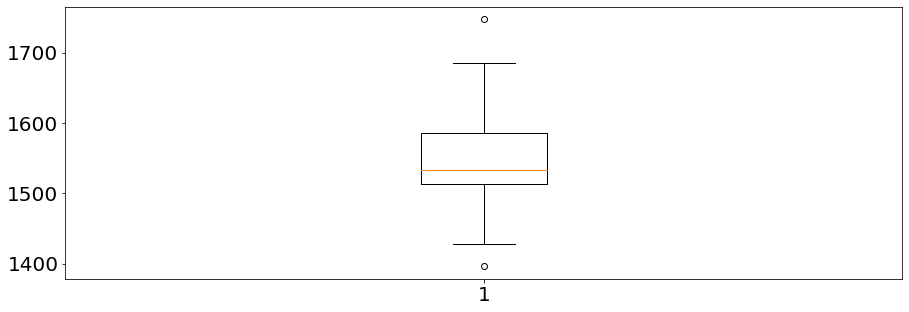

In [16]:
# Summarize scores via box plot
summarize_scores(scores)

# Conclusions
<hr style="border:2px solid black"> </hr>

<div class="alert alert-danger">
<font color=black>

- We saw how the spread of the results is a bit large.
- CNNs like any other ANNs have higher skills and harnessing them, meaning minimising their variance across multiple runs is a **challenge**.
- There are many fixes. The simplest is simply to train multiple final models for use in an ensemble.
- **Walk-Forward**, please note that you can also refit the model at each step. This could further improve model performance.

</font>
</div>

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv
- https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/    
- [Deep learning: the final frontier for signal processing and time series analysis?](https://alexrachnog.medium.com/deep-learning-the-final-frontier-for-signal-processing-and-time-series-analysis-734307167ad6)
- Moroney, Laurence. AI and Machine Learning for coders. O'Reilly Media, 2020.

</font>
</div>